# Project Overview

This project aims to predict how long it will take to resolve a JIRA ticket based on various ticket attributes, including metadata and natural language descriptions. The input data is taken from a real-world JIRA export from Kaggle.

## Problem Statement

The goal is to accurately predict the resolution duration (in days) for each JIRA ticket. Predicting ticket duration helps project managers allocate resources, set expectations, and improve team planning.

## Metrics

We evaluate model performance using:
- **Mean Absolute Error (MAE):** Easy to interpret and robust to outliers.
- **Root Mean Squared Error (RMSE):** Sensitive to large errors, useful when penalizing larger mistakes more.

These are appropriate for regression tasks where we want to understand both the average error and sensitivity to larger mistakes.

In [1]:
pip install boto3 xgboost lightgbm tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 21.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 163.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 150.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 161.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 168.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 120.2 MB/s eta 0:00:00
  Created wheel for lightgbm: filename=lightgbm-4.6.0-py3-none-linux_x86_64.whl size=2737776 sha256=c99894

In [2]:
import boto3
import pandas as pd
from io import StringIO

# AWS S3 bucket and file details
bucket_name = 'sagemaker-us-east-1-975049930129'
file_key = 'udacity-proj/GFG_FINAL 2.csv'

# Initialize an S3 client
s3_client = boto3.client('s3')

# Read the file content from S3
response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
csv_content = response['Body'].read().decode('utf-8')

# Load the CSV content into a Pandas DataFrame
jira_data = pd.read_csv(StringIO(csv_content))

# Inspect the data
print(jira_data.head())
print(jira_data.info())

                                             Summary         Issue key  \
0  Sourcetree repository tab width automatically ...  SRCTREEWIN-14221   
1  Stashes don't show untracked files when clicki...  SRCTREEWIN-14215   
2                        Beyond compare not starting  SRCTREEWIN-14211   
3  Displaying all changes between hash1 and hash2...  SRCTREEWIN-14210   
4  Displaying all changes between hash1 and hash2...  SRCTREEWIN-14209   

   Issue id Issue Type              Status Project key  \
0   1949800        Bug  Short Term Backlog  SRCTREEWIN   
1   1946072        Bug  Short Term Backlog  SRCTREEWIN   
2   1945187        Bug    Gathering Impact  SRCTREEWIN   
3   1945171        Bug              Closed  SRCTREEWIN   
4   1945161        Bug              Closed  SRCTREEWIN   

             Project name Project type Project lead  Project description  ...  \
0  Sourcetree for Windows     software       rgomis                  NaN  ...   
1  Sourcetree for Windows     software      

In [4]:
## Data Cleaning

# Identify all columns with "Comment" in their name
comment_columns = [col for col in jira_data.columns if 'Comment' in col]

# Define other columns to keep
other_columns = ['Summary', 'Status', 'Issue Type', 'Resolution', 
                 'Priority', 'Created', 'Updated', 'Resolved', 'Description']

# Combine the lists
columns_to_keep = other_columns + comment_columns

# Select only those columns
jira_data = jira_data[columns_to_keep]

# Filter out rows where the 'Resolved' column is null or has invalid values
jira_data = jira_data[jira_data['Resolved'].notnull()]

jira_data['Created'] = pd.to_datetime(jira_data['Created'])
jira_data['Updated'] = pd.to_datetime(jira_data['Updated'])
# Convert the 'Resolved' column to datetime after filtering
jira_data['Resolved'] = pd.to_datetime(jira_data['Resolved'], errors='coerce')

print(jira_data.head())
print(jira_data.info())

                                              Summary  Status  Issue Type  \
3   Displaying all changes between hash1 and hash2...  Closed         Bug   
4   Displaying all changes between hash1 and hash2...  Closed         Bug   
16                                   GlucoTru Reviews  Closed  Suggestion   
20     Primal Beast Male Enhancement official reviews  Closed         Bug   
21           Primal Beast Male Enhancement get it now  Closed         Bug   

   Resolution Priority             Created             Updated  \
3   Not a bug      Low 2023-05-22 20:49:00 2023-05-30 10:04:00   
4   Duplicate      Low 2023-05-22 13:31:00 2023-05-30 09:56:00   
16       Spam      NaN 2023-04-14 10:04:00 2023-04-14 15:11:00   
20      Fixed     High 2023-03-29 09:54:00 2023-04-10 09:08:00   
21       Spam     High 2023-03-29 09:53:00 2023-04-10 09:09:00   

              Resolved                                        Description  \
3  2023-05-30 10:04:00  When I'm selecting multiple nodes the f

In [5]:
## Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

jira_data = pd.get_dummies(jira_data, columns=['Status', 'Issue Type', 'Resolution', 'Priority'])


vectorizer = TfidfVectorizer(max_features=100)
text_features = vectorizer.fit_transform(jira_data['Description']).toarray()

jira_data['Duration'] = (jira_data['Resolved'] - jira_data['Created']).dt.days

# Identify all columns with "Comment" in their name
comment_columns = [col for col in jira_data.columns if 'Comment' in col]

# Ensure all values in 'Comment' columns are strings
jira_data[comment_columns] = jira_data[comment_columns].fillna('').astype(str)

# Aggregate all 'Comment' columns into a single column
jira_data['Aggregated_Comment'] = jira_data[comment_columns].agg(' '.join, axis=1)

# Calculate the Activity Level based on the aggregated comments
jira_data['Activity Level'] = jira_data['Aggregated_Comment'].apply(lambda x: len(x.split()))

# Inspect the resulting DataFrame
print(jira_data[['Aggregated_Comment', 'Activity Level']].head())

                                   Aggregated_Comment  Activity Level
3   1.0 30/May/2023 10:04 AM;698877135425;When sel...              60
4   1.0 30/May/2023 9:56 AM;698877135425;Closing t...              12
16  1.0 14/Apr/2023 3:11 PM;9db362c0c6b2;Not relat...               7
20  2.0 29/Mar/2023 2:55 PM;9db362c0c6b2;Not relat...              23
21  2.0 29/Mar/2023 2:55 PM;9db362c0c6b2;Not relat...              23


In [5]:
# Target variable and features
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Separate features and target
target = 'Duration'
X = jira_data.drop(columns=[target])
y = jira_data[target]

# Identify categorical and text columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
text_columns = ['Description']

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(X[categorical_columns])

# Process text columns with TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
tfidf_features = vectorizer.fit_transform(X[text_columns[0]].fillna('')).toarray()

# Drop processed columns from X
X = X.drop(columns=categorical_columns + text_columns).reset_index(drop=True)

# Convert encoded features and text features to DataFrames
import pandas as pd
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns))
tfidf_df = pd.DataFrame(tfidf_features, columns=[f'TF_IDF_{i}' for i in range(tfidf_features.shape[1])])

# Concatenate processed features with the rest of X
X = pd.concat([X, encoded_df, tfidf_df], axis=1)

In [6]:
# Split your data into training and testing sets.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Normalize/Scale Features

# Convert datetime columns to numeric (epoch time in seconds)
datetime_columns = ['Created', 'Updated', 'Resolved']

for col in datetime_columns:
    X_train[col] = pd.to_datetime(X_train[col]).astype(int) / 10**9
    X_test[col] = pd.to_datetime(X_test[col]).astype(int) / 10**9

# Ensure 'Duration' is numeric
if 'Duration' in X_train.columns:
    X_train['Duration'] = X_train['Duration'].astype(float)
    X_test['Duration'] = X_test['Duration'].astype(float)

# Drop non-numeric columns
X_train = X_train.select_dtypes(include=['float64', 'int64'])
X_test = X_test.select_dtypes(include=['float64', 'int64'])

# Scale the numeric features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Train a simple linear regression model as a baseline.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train the model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = linear_model.predict(X_test_scaled)
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred))
print("Linear Regression RMSE:", mean_squared_error(y_test, y_pred))

heuristic_pred = [y_train.mean()] * len(y_test)  # Predict mean of training target
print("Heuristic MAE:", mean_absolute_error(y_test, heuristic_pred))

Linear Regression MAE: 2.1635801109245925e-12
Linear Regression RMSE: 1.0255976017049424e-23
Heuristic MAE: 160.1165423826074


In [9]:
# Use Random Forest for structured data.

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))

Random Forest MAE: 0.0


In [10]:
# Train an XGBoost model for enhanced performance

from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


XGBoost MAE: 0.28973284363746643


In [11]:
# Use LightGBM for structured data.

import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

y_pred_lgb = lgb_model.predict(X_test_scaled)
print("LightGBM MAE:", mean_absolute_error(y_test, y_pred_lgb))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13210
[LightGBM] [Info] Number of data points in the train set: 13249, number of used features: 2239
[LightGBM] [Info] Start training from score 188.512944
LightGBM MAE: 0.1936900292938517


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [12]:
# Train Deep Learning Models

from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout

vectorizer = TfidfVectorizer(max_features=100)
text_features = vectorizer.fit_transform(jira_data['Aggregated_Comment']).toarray()

# Example LSTM model for text data
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=text_features.shape[1]),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(text_features, y, epochs=10, batch_size=32)

2025-04-12 15:17:20.847060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744471041.082137    8544 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744471041.144009    8544 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744471041.723879    8544 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744471041.723913    8544 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744471041.723916    8544 computation_placer.cc:177] computation placer alr

Epoch 1/10


2025-04-12 15:17:42.633012: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


518/518 ━━━━━━━━━━━━━━━━━━━━ 94s 175ms/step - loss: 67083.6562 - mae: 168.7849
Epoch 2/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 141s 174ms/step - loss: 52693.4609 - mae: 162.5692
Epoch 3/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 137s 163ms/step - loss: 51967.5000 - mae: 163.4505
Epoch 4/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 150s 178ms/step - loss: 51157.1562 - mae: 161.8100
Epoch 5/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 143s 181ms/step - loss: 50692.6953 - mae: 163.2529
Epoch 6/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 142s 181ms/step - loss: 51788.1680 - mae: 163.2665
Epoch 7/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 135s 168ms/step - loss: 49243.6406 - mae: 160.9340
Epoch 8/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 89s 171ms/step - loss: 52878.5820 - mae: 163.6512
Epoch 9/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 149s 184ms/step - loss: 49787.3242 - mae: 162.4647
Epoch 10/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 136s 173ms/step - loss: 49443.3984 - mae: 161.2891


In [13]:
# Combine Structured and Unstructured Data

from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model

# Inputs
structured_input = Input(shape=(X_train_scaled.shape[1],))
text_input = Input(shape=(text_features.shape[1],))

# Structured Model
x = Dense(64, activation='relu')(structured_input)

# Text Model
y = Embedding(input_dim=10000, output_dim=128)(text_input)
y = LSTM(128)(y)

# Combine
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dense(1, activation='linear')(z)

# Define the Model
multi_modal_model = Model(inputs=[structured_input, text_input], outputs=z)
multi_modal_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

text_features = text_features[:X_train_scaled.shape[0], :]

y_train = y_train[:X_train_scaled.shape[0]]

# Train the model
multi_modal_model.fit([X_train_scaled, text_features], y_train, epochs=10, batch_size=32)

Epoch 1/10


2025-04-12 15:41:08.455036: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 118658044 exceeds 10% of free system memory.


415/415 ━━━━━━━━━━━━━━━━━━━━ 75s 174ms/step - loss: 42041.8438 - mae: 105.1626
Epoch 2/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 75s 180ms/step - loss: 14.2828 - mae: 1.2231
Epoch 3/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 78s 171ms/step - loss: 142.5811 - mae: 2.3544
Epoch 4/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 88s 185ms/step - loss: 234.1819 - mae: 3.3274
Epoch 5/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 80s 181ms/step - loss: 210.5427 - mae: 3.2103
Epoch 6/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 78s 187ms/step - loss: 200.9445 - mae: 4.1011
Epoch 7/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 75s 180ms/step - loss: 242.9497 - mae: 3.9476
Epoch 8/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 77s 170ms/step - loss: 196.2056 - mae: 3.7435
Epoch 9/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 90s 190ms/step - loss: 215.8810 - mae: 4.8173
Epoch 10/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 71s 164ms/step - loss: 221.8622 - mae: 3.8669


In [17]:
import tensorflow as tf
import boto3
import os
import tarfile

# Step 1: Save Model to Path
model_dir = os.path.join("export", "Servo", "1")
os.makedirs(model_dir, exist_ok=True)

tf.saved_model.save(multi_modal_model, model_dir)

# Step 2: Verify `saved_model.pb` Exists in the Correct Location
if "saved_model.pb" not in os.listdir(model_dir):
    raise ValueError("❌ ERROR: 'saved_model.pb' not found! Model may not have been saved correctly.")

print("Model directory contains:", os.listdir(model_dir))

tar_model_path = "jira_estimate_model.tar.gz"
with tarfile.open(tar_model_path, "w:gz") as tar:
    tar.add("export", arcname="model/export")

print("Tar file created successfully!")

# Step 4: Upload Model to S3
s3_bucket = "sagemaker-us-east-1-975049930129"
s3_model_path = f"s3://{s3_bucket}/jira_estimate_model.tar.gz"

s3 = boto3.client("s3")
s3.upload_file(tar_model_path, s3_bucket, "jira_estimate_model.tar.gz")

print(f" Model successfully uploaded to {s3_model_path}")

INFO:tensorflow:Assets written to: export/Servo/1/assets


INFO:tensorflow:Assets written to: export/Servo/1/assets


Model directory contains: ['assets', 'variables', 'fingerprint.pb', 'saved_model.pb']
Tar file created successfully!
 Model successfully uploaded to s3://sagemaker-us-east-1-975049930129/jira_estimate_model.tar.gz


In [18]:
import sagemaker
from sagemaker.tensorflow import TensorFlowModel
from sagemaker import get_execution_role

# Initialize SageMaker session
sagemaker_session = sagemaker.Session()

# Define TensorFlow Model in SageMaker with Env Variable
tensorflow_model = TensorFlowModel(
    model_data=f"s3://{s3_bucket}/jira_estimate_model.tar.gz",
    role=get_execution_role(),
    framework_version="2.16",
    sagemaker_session=sagemaker_session,
    env={
        "SAGEMAKER_TFS_DEFAULT_MODEL_NAME": "Servo",
        "SAGEMAKER_TFS_MODEL_VERSION_POLICY": "latest",
        "SAGEMAKER_TFS_ENABLE_METRICS": "true",
        "SAGEMAKER_TFS_WAIT_TIME_SECONDS": "300"
    }
)

predictor = tensorflow_model.deploy(instance_type="ml.g4dn.xlarge", initial_instance_count=1)

print("Model deployed successfully!")

----------!Model deployed successfully!


In [20]:
import json
import numpy as np
import boto3

# Convert structured features to float32
structured_features = np.array(X_test_scaled[0], dtype=np.float32).tolist()

# Convert text_description into a 100-dimensional vector
text_description = "Implement a new login authentication system with two-factor authentication."
text_vector = vectorizer.transform([text_description]).toarray()[0].astype(np.float32).tolist()

# Construct payload
payload = {
    "instances": [
        {
            "inputs": structured_features,
            "inputs_1": text_vector
        }
    ]
}

# Convert payload to JSON bytes
payload_bytes = json.dumps(payload).encode("utf-8")  # 🔹 Ensure UTF-8 encoding

runtime = boto3.client("sagemaker-runtime", region_name="us-east-1")  # 🔹 Change region if needed
response = runtime.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType="application/json",
    Body=payload_bytes  # 🔹 Send as raw JSON bytes
)

# Read response
result = response["Body"].read().decode("utf-8")
print("Predicted Output:", result)

Predicted Output: {'predictions': [[3.742]]}


In [21]:
predictor.delete_endpoint()
print("SageMaker endpoint deleted.")

SageMaker endpoint deleted.


## Exploratory Visualization

Here’s a histogram of ticket resolution durations to understand distribution and identify skew or outliers.

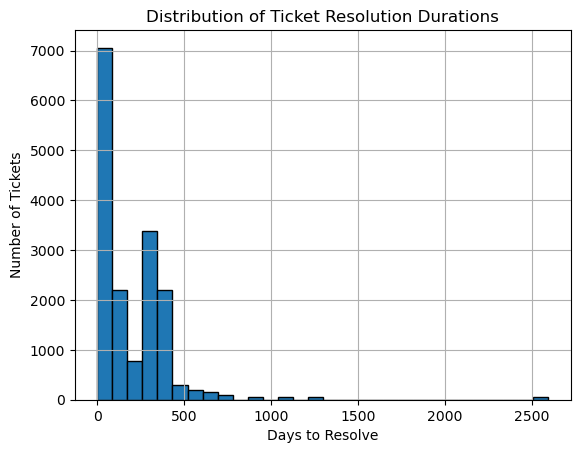

In [6]:

import matplotlib.pyplot as plt
plt.hist(jira_data['Duration'], bins=30, edgecolor='black')
plt.title('Distribution of Ticket Resolution Durations')
plt.xlabel('Days to Resolve')
plt.ylabel('Number of Tickets')
plt.grid(True)
plt.show()
